In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Merge All images from different folder


In [ ]:
import os
import shutil

# Paths
source_root = "/content/drive/MyDrive/cataract/Normal/"   # parent folder that contains many subfolders with images
destination = "/content/drive/MyDrive/processed_images/train/normal/"

# Create destination folder if not exists
os.makedirs(destination, exist_ok=True)

# Allowed image extensions
extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

# Counter for unique filenames
counter = 1

for root, dirs, files in os.walk(source_root):
    for file in files:
        if file.lower().endswith(extensions):
            src_path = os.path.join(root, file)

            # Create unique filename to avoid overwriting
            new_filename = f"image_{counter}{os.path.splitext(file)[1]}"
            dst_path = os.path.join(destination, new_filename)

            shutil.copy2(src_path, dst_path)  # copy image
            # shutil.move(src_path, dst_path)  # use this if you want to MOVE instead of copy

            counter += 1

print(f"✅ All images have been merged into: {destination}")




In [ ]:
import os

# Path to the main directory containing class folders
DATA_DIR = "/content/drive/MyDrive/processed_images/train"

# Allowed image extensions
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Loop through each subfolder
for folder_name in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.isdir(folder_path):
        count = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(IMG_EXTENSIONS)
        ])
        print(f"Folder '{folder_name}': {count} images")


create label.txt for yolo training

In [ ]:
import json
import os
from tqdm import tqdm
import cv2

# ---- Config ----
coco_json = "/content/drive/MyDrive/labels_test_catarct.json"   # COCO annotation file
output_dir = "/content/drive/MyDrive/only_pupil/labels"          # where YOLO txt files will go
images_dir = "/content/drive/MyDrive/only_pupil/images"          # your images folder

os.makedirs(output_dir, exist_ok=True)

# ---- Load COCO ----
with open(coco_json) as f:
    coco = json.load(f)

# Map image_id → file_name
id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}

# Create YOLO txt per image
for ann in tqdm(coco["annotations"], desc="Converting"):
    img_id = ann["image_id"]
    bbox = ann["bbox"]  # [x, y, width, height]

    # Force single class (pupil = 0)
    class_id = 0

    # Convert to YOLO format
    x, y, w, h = bbox
    img_filename = id_to_filename[img_id]
    img_path = os.path.join(images_dir, img_filename)

    # Load image size (for normalization)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Warning: Could not read image {img_path}. Skipping annotation.")
        continue

    H, W = img.shape[:2]

    x_center = (x + w / 2) / W
    y_center = (y + h / 2) / H
    w /= W
    h /= H

    # YOLO line
    yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n"

    # Save
    label_filename = os.path.splitext(img_filename)[0] + ".txt"
    with open(os.path.join(output_dir, label_filename), "a") as f:
        f.write(yolo_line)

print("✅ COCO → YOLO conversion complete! Labels saved in:", output_dir)


Split Dataset


In [ ]:
import os
import shutil
import random

# ---- Config ----
images_dir = "/content/drive/MyDrive/only_pupil/images"   # all images
labels_dir = "/content/drive/MyDrive/only_pupil/labels"   # all labels
output_dir = "/content/drive/MyDrive/only_pupil_split"    # output root folder

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create output folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

# Get all images
all_images = [f for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random.shuffle(all_images)

# Split counts
total = len(all_images)
train_count = int(total * train_ratio)
val_count = int(total * val_ratio)

train_files = all_images[:train_count]
val_files = all_images[train_count:train_count + val_count]
test_files = all_images[train_count + val_count:]

splits = {"train": train_files, "val": val_files, "test": test_files}

# Copy images and labels
for split, files in splits.items():
    for f in files:
        # Copy image
        shutil.copy2(os.path.join(images_dir, f), os.path.join(output_dir, "images", split, f))

        # Copy corresponding label
        label_file = os.path.splitext(f)[0] + ".txt"
        shutil.copy2(os.path.join(labels_dir, label_file), os.path.join(output_dir, "labels", split, label_file))

print("✅ Dataset split complete!")
print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")


Pupil Detection Model

In [ ]:
pip install -U ultralytics


In [20]:
from ultralytics import YOLO

# YOLOv8 model
v8_model = YOLO("yolov8n.pt")
v8_results = v8_model.train(
    data="/content/drive/MyDrive/cataract/pupil_detection/data.yaml",
    epochs=10,              # 👉 barate hobe (50 → 100/150) for better convergence
    imgsz=512,               # thik ache, but try 512 if GPU low
    batch=16,
    patience=30,             # 👉 early stopping
    optimizer="AdamW",       # 👉 better optimizer than SGD for small datasets
    lr0=0.001,               # 👉 custom learning rate (default 0.01 too high)
    lrf=0.01,                # final lr ratio
    dropout=0.05,            # 👉 prevent overfitting
    mosaic=1.0,              # 👉 enable strong augmentation
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, # 👉 color augmentation
    scale=0.5, flipud=0.5, fliplr=0.5, # 👉 geometric augmentation
    project="runs_pupil",
    name="yolov8_pupil_tuned"
)

# YOLO latest (YOLOv10/11)
v10_model = YOLO("yolo11n.pt")
v10_results = v10_model.train(
    data="/content/drive/MyDrive/cataract/pupil_detection/data.yaml",
    epochs=10,
    imgsz=512,
    batch=16,
    patience=30,
    optimizer="AdamW",
    lr0=0.001,
    lrf=0.01,
    dropout=0.05,
    mosaic=1.0,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    scale=0.5, flipud=0.5, fliplr=0.5,
    project="runs_pupil",
    name="yolov10_pupil_tuned"
)


Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/cataract/pupil_detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.05, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_pupil_tuned2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=30, persp

train: Scanning /content/drive/MyDrive/cataract/pupil_detection/labels/train.cache... 244 images, 254 backgrounds, 0 corrupt: 100%|██████████| 498/498 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.9±1.1 ms, read: 105.3±135.1 MB/s, size: 7759.5 KB)


val: Scanning /content/drive/MyDrive/cataract/pupil_detection/labels/val.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]


Plotting labels to runs_pupil/yolov8_pupil_tuned2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs_pupil/yolov8_pupil_tuned2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.69G      1.174      3.257      1.252          0        512: 100%|██████████| 32/32 [02:48<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        127        127    0.00733      0.291     0.0187    0.00397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.69G      1.062      1.576      1.174          1        512: 100%|██████████| 32/32 [02:44<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        127        127      0.273      0.992      0.682      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.69G      1.007      1.438      1.132          2        512: 100%|██████████| 32/32 [02:37<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        127        127       0.92      0.636       0.89      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.69G     0.9347       1.36      1.094          0        512: 100%|██████████| 32/32 [02:40<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        127        127      0.918      0.819      0.937      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.69G     0.9611       1.33      1.104          1        512: 100%|██████████| 32/32 [02:42<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        127        127      0.945      0.941      0.984      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.69G      0.932      1.274      1.047          1        512: 100%|██████████| 32/32 [02:43<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all        127        127      0.992      0.982      0.993       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.69G     0.8748      1.227       1.07          2        512: 100%|██████████| 32/32 [02:42<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        127        127      0.996      0.992      0.995      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.69G     0.8623       1.23      1.014          1        512: 100%|██████████| 32/32 [02:40<00:00,  5.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        127        127       0.99          1      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.69G     0.8152      1.134     0.9981          2        512: 100%|██████████| 32/32 [02:42<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        127        127      0.984      0.994      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.69G     0.7873       1.15     0.9762          1        512: 100%|██████████| 32/32 [02:46<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        127        127          1      0.998      0.995      0.777



10 epochs completed in 0.464 hours.
Optimizer stripped from runs_pupil/yolov8_pupil_tuned2/weights/last.pt, 6.2MB
Optimizer stripped from runs_pupil/yolov8_pupil_tuned2/weights/best.pt, 6.2MB

Validating runs_pupil/yolov8_pupil_tuned2/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:53<00:00, 13.44s/it]


                   all        127        127      0.993      0.992      0.995      0.789
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs_pupil/yolov8_pupil_tuned2
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/cataract/pupil_detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.05, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=3

train: Scanning /content/drive/MyDrive/cataract/pupil_detection/labels/train.cache... 244 images, 254 backgrounds, 0 corrupt: 100%|██████████| 498/498 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 7.8±14.1 ms, read: 37.9±38.4 MB/s, size: 7759.5 KB)


val: Scanning /content/drive/MyDrive/cataract/pupil_detection/labels/val.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]


Plotting labels to runs_pupil/yolov10_pupil_tuned/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs_pupil/yolov10_pupil_tuned
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.68G      1.183       3.27      1.342          0        512: 100%|██████████| 32/32 [03:40<00:00,  6.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.38s/it]

                   all        127        127    0.00362      0.236     0.0265    0.00612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.95G      1.017      1.569      1.225          1        512: 100%|██████████| 32/32 [02:32<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        127        127      0.884       0.18      0.254      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.95G     0.9847      1.406      1.164          2        512: 100%|██████████| 32/32 [02:45<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        127        127      0.148     0.0709     0.0863     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.96G     0.9497      1.336      1.161          0        512: 100%|██████████| 32/32 [02:48<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        127       0.64      0.617      0.724      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.96G     0.9569        1.3      1.168          1        512: 100%|██████████| 32/32 [02:52<00:00,  5.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        127      0.886      0.953      0.945      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.96G     0.8939      1.232      1.099          1        512: 100%|██████████| 32/32 [02:51<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        127        127      0.948      0.953      0.986      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.97G     0.8783      1.201      1.145          2        512: 100%|██████████| 32/32 [02:53<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        127        127      0.992       0.99      0.995      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.98G     0.8641       1.21      1.111          1        512: 100%|██████████| 32/32 [02:48<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        127        127          1      0.997      0.995      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         2G     0.8441      1.159      1.102          2        512: 100%|██████████| 32/32 [02:49<00:00,  5.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        127        127      0.992      0.988      0.995      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.01G     0.7965       1.17      1.059          1        512: 100%|██████████| 32/32 [02:57<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        127          1      0.991      0.995      0.793



10 epochs completed in 0.499 hours.
Optimizer stripped from runs_pupil/yolov10_pupil_tuned/weights/last.pt, 5.4MB
Optimizer stripped from runs_pupil/yolov10_pupil_tuned/weights/best.pt, 5.4MB

Validating runs_pupil/yolov10_pupil_tuned/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.55s/it]


                   all        127        127          1      0.991      0.995      0.793
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs_pupil/yolov10_pupil_tuned


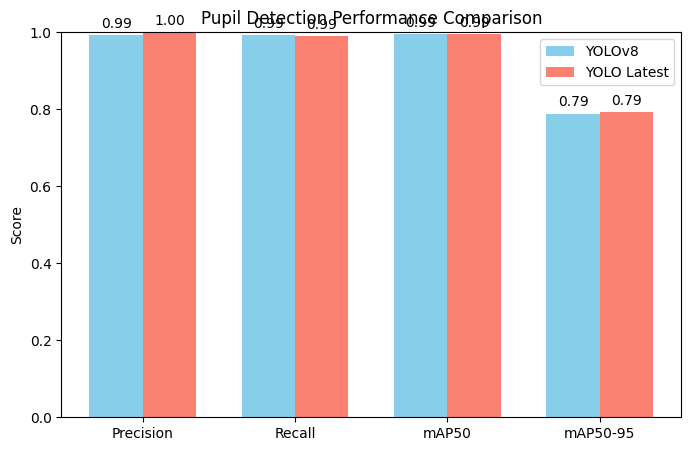

In [21]:
# Extract metrics
v8_metrics = v8_results.results_dict  # precision, recall, mAP50, mAP50-95
v10_metrics = v10_results.results_dict

import matplotlib.pyplot as plt
import numpy as np

# Metrics to compare
metrics_names = ["Precision", "Recall", "mAP50", "mAP50-95"]
v8_values = [v8_metrics['metrics/precision(B)'], v8_metrics['metrics/recall(B)'], v8_metrics['metrics/mAP50(B)'], v8_metrics['metrics/mAP50-95(B)']]
v10_values = [v10_metrics['metrics/precision(B)'], v10_metrics['metrics/recall(B)'], v10_metrics['metrics/mAP50(B)'], v10_metrics['metrics/mAP50-95(B)']]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, v8_values, width, label='YOLOv8', color='skyblue')
rects2 = ax.bar(x + width/2, v10_values, width, label='YOLO Latest', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Pupil Detection Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0,1)
ax.legend()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [23]:
import cv2
import os
from tqdm import tqdm

# -----------------------------
# Paths
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/processed_images/train/"         # original dataset
SAVE_DIR = "/content/drive/MyDrive/processed_images_clean"  # processed dataset

os.makedirs(SAVE_DIR, exist_ok=True)

# -----------------------------
# Image processing settings
# -----------------------------
# FastNlMeansDenoisingColored parameters
h = 10          # filter strength for luminance
hColor = 10     # filter strength for color
templateWindowSize = 7
searchWindowSize = 21

# Sharpening kernel
sharpen_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
sharpen_filter = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32)

# -----------------------------
# Process images
# -----------------------------
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    save_class_path = os.path.join(SAVE_DIR, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # 1️⃣ Noise removal
            denoised = cv2.fastNlMeansDenoisingColored(img, None, h, hColor,
                                                       templateWindowSize, searchWindowSize)

            # 2️⃣ Mild sharpening
            sharpened = cv2.filter2D(denoised, -1, sharpen_filter)

            # Save processed image
            save_path = os.path.join(save_class_path, img_name)
            cv2.imwrite(save_path, sharpened)


Processing normal: 100%|██████████| 804/804 [11:30<00:00,  1.16it/s]
